In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import os
import sys
import sklearn
from sklearn import linear_model
import shap
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/final-data/Test.csv


In [2]:
def computeCost(X,y,theta):  
    tobesummed = np.power(((X @ theta.T)-y),2)  
    return np.sum(tobesummed)/(2 * len(X))  
  
def gradientDescent(X,y,theta,iters,alpha):  
    cost = np.zeros(iters)  
    for i in range(iters):  
        theta = theta - (alpha/len(X)) * np.sum(X * (X @ theta.T - y), axis=0)  
        cost[i] = computeCost(X, y, theta)  
      
    return theta,cost  

In [3]:
def floater(a):  # .astype() can be used but is not reliable
    b = []
    for i in a:
        try:
            ix = []
            for j in i:
                ix.append(float(j))
        except:
            ix = float(i)
            pass
        b.append(ix)
    b = np.array(b)
    return b

In [4]:
def normalize(matrix, r, n, m):
    for j in range(m):
        sq = np.sqrt(sum(matrix[:, j]**2))
        for i in range(n):
            r[i, j] = matrix[i, j]/sq
    return r


def weight_product(matrix, weight):
    prod = matrix*weight
    return prod

In [5]:
def calc_ideal_best_worst(sign, matrix, n, m):
    ideal_worst = []
    ideal_best = []
    for i in range(m):
        if sign[i]>0:
            ideal_worst.append(min(matrix[:, i]))
            ideal_best.append(max(matrix[:, i]))
        else:
            ideal_worst.append(max(matrix[:, i]))
            ideal_best.append(min(matrix[:, i]))
    return (ideal_worst, ideal_best)

In [6]:
def euclidean_distance(matrix, ideal_worst, ideal_best, n, m):
    diw = (matrix - ideal_worst)**2
    dib = (matrix - ideal_best)**2
    dw = []
    db = []
    for i in range(n):
        dw.append(sum(diw[i, :])**0.5)
        db.append(sum(dib[i, :])**0.5)
    dw = np.array(dw)
    db = np.array(db)
    return (dw, db)

In [7]:
def performance_score(distance_best, distance_worst, n, m):
    score = []
    score = distance_worst/(distance_best + distance_worst)
    return score

def topsis(a, w, sign):
    a = floater(a)
    n = len(a)
    m = len(a[0])
    r = np.empty((n, m), np.float64)
    r = normalize(a, r, n, m)
    t = weight_product(r, w)
    (ideal_worst, ideal_best) = calc_ideal_best_worst(sign, t, n, m)
    (distance_worst, distance_best) = euclidean_distance(
        t, ideal_worst, ideal_best, n, m)
    score = performance_score(distance_best, distance_worst, n, m)
    column_name=['score']
    return pd.DataFrame(data=score,columns=column_name)

In [8]:
def rank(url):
    train=pd.read_csv(url)
    X=train.iloc[:,1:17]
    Name=train.iloc[:,0:1]
    X=X.astype(float)
    columns=X.columns
    columns=columns.insert(0,'bias')
    y=train.iloc[:,-1:].values
    y=y.astype(float)
    ones = np.ones([X.shape[0],1])  
    X = np.concatenate((ones,X),axis=1)  
    theta = np.zeros([1,17])  
    alpha = 0.01
    iters = 200
    w,cost = gradientDescent(X,y,theta,iters,alpha)    
    finalCost = computeCost(X,y,w)  
    score=topsis(X,w,y)
    data = [Name["Name"], score["score"]]
    headers = ["Name", "score"]
    score_card= pd.concat(data, axis=1, keys=headers)
    result=score_card.sort_values(by='score',ascending=False)
    X_train_summary = shap.kmeans(X, 10)
    lin_regr = linear_model.LinearRegression()
    lin_regr.fit(X, y)
    ex = shap.KernelExplainer(lin_regr.predict, X)
    shap_values = ex.shap_values(X)
    shap.summary_plot(shap_values, features=X, feature_names=columns)
    return result

  0%|          | 0/32 [00:00<?, ?it/s]

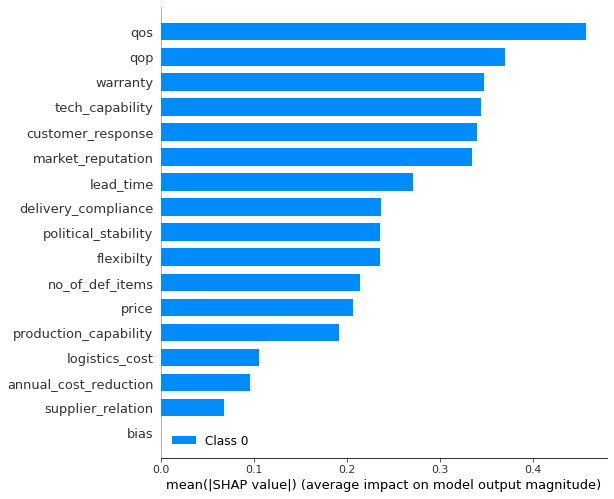

,Name,score
3,D,0.844351
0,A,0.835616
1,B,0.834378
2,C,0.769826
31,AF,0.756174
16,Q,0.726324
4,E,0.724523
17,R,0.689920
19,T,0.661813
20,U,0.632099


In [9]:
url='../input/final-data/Test.csv'
rank(url)